# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

Шаги по выполнению проекта:
1. Загрузка данных
2. Подготовка  данных
3. Обучение моделей
4. Анализ моделей (сравнение)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from datetime import datetime
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from time import time
import warnings
import logging

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
RANDOM_STATE = 42
TEST_SIZE= 0.25

## Загрузка данных

Загрузим данные и сразу пропарсим datetime тип

In [3]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('datasets/autos.csv',
                 parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], date_parser=dateparse)

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Тип данных в столбцах корректный, переведем название столбцов в змейиный регистр

In [6]:
df.columns = list(map(lambda x: x.lower(), list(df)))

In [7]:
df = df.rename(columns = {'datecrawled': 'date_crawled',
                     'vehicletype': 'vehicle_type',
                     'registrationyear': 'registration_year',
                     'registrationmonth': 'registration_month',
                     'fueltype': 'fuel_type',
                     'datecreated': 'date_created',
                     'numberofpictures': 'number_of_pictures',
                     'postalcode': 'postal_code',
                     'lastseen': 'last_seen'})

Переведем колонки типа object в нижний регистр для обработки дубликатов

In [8]:
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.lower()

Посмотрим на количество пропусков

In [9]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Отработаем их на следущем шаге

Рассмотрим неявные дубликаты

In [10]:
for col in df.select_dtypes(include='object'):
    print(f'{col.upper()} \n {df[col].value_counts()}\n')

VEHICLE_TYPE 
 vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

GEARBOX 
 gearbox
manual    268251
auto       66285
Name: count, dtype: int64

MODEL 
 model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

FUEL_TYPE 
 fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

BRAND 
 brand
volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25

Удалим данный столбцы которые для нас никакой полезной информации не несут

In [11]:
df = df.drop(['date_created', 'postal_code', 'last_seen', 'number_of_pictures'], axis=1)

Удалим дубликаты, поскольку они негативно повлияют на прогноз моделей

In [12]:
df = df.drop_duplicates()

**Промежуточный вывод**
- Были загружены и просмотренны исходные данные
- Были переименнованы столбцы в змейиный регистр
- `object` столбцы были переведены в нижний регистр для обработки дубликатов
- Были удалены ненужные для прогноза столбцы

## Подготовка данных

In [13]:
df.select_dtypes(include='number').describe()

,price,registration_year,power,kilometer,registration_month
count,354344.000000,354344.000000,354344.000000,354344.000000,354344.000000
mean,4416.561477,2004.234563,110.091352,128212.330391,5.714574
std,4514.167328,90.231117,189.855996,37904.408738,3.726447
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [14]:
def histplot(data):
    plt.figure(figsize=(16, 9))
    plt.suptitle('Распределение числовых значений', fontsize=15)
    columns_names = df.select_dtypes(include='number')

    for i, col in zip(range(1, 7), columns_names):
        plt.subplot(2,3,i)
        sns.histplot(data=data, x=col, kde=True)
    plt.tight_layout()

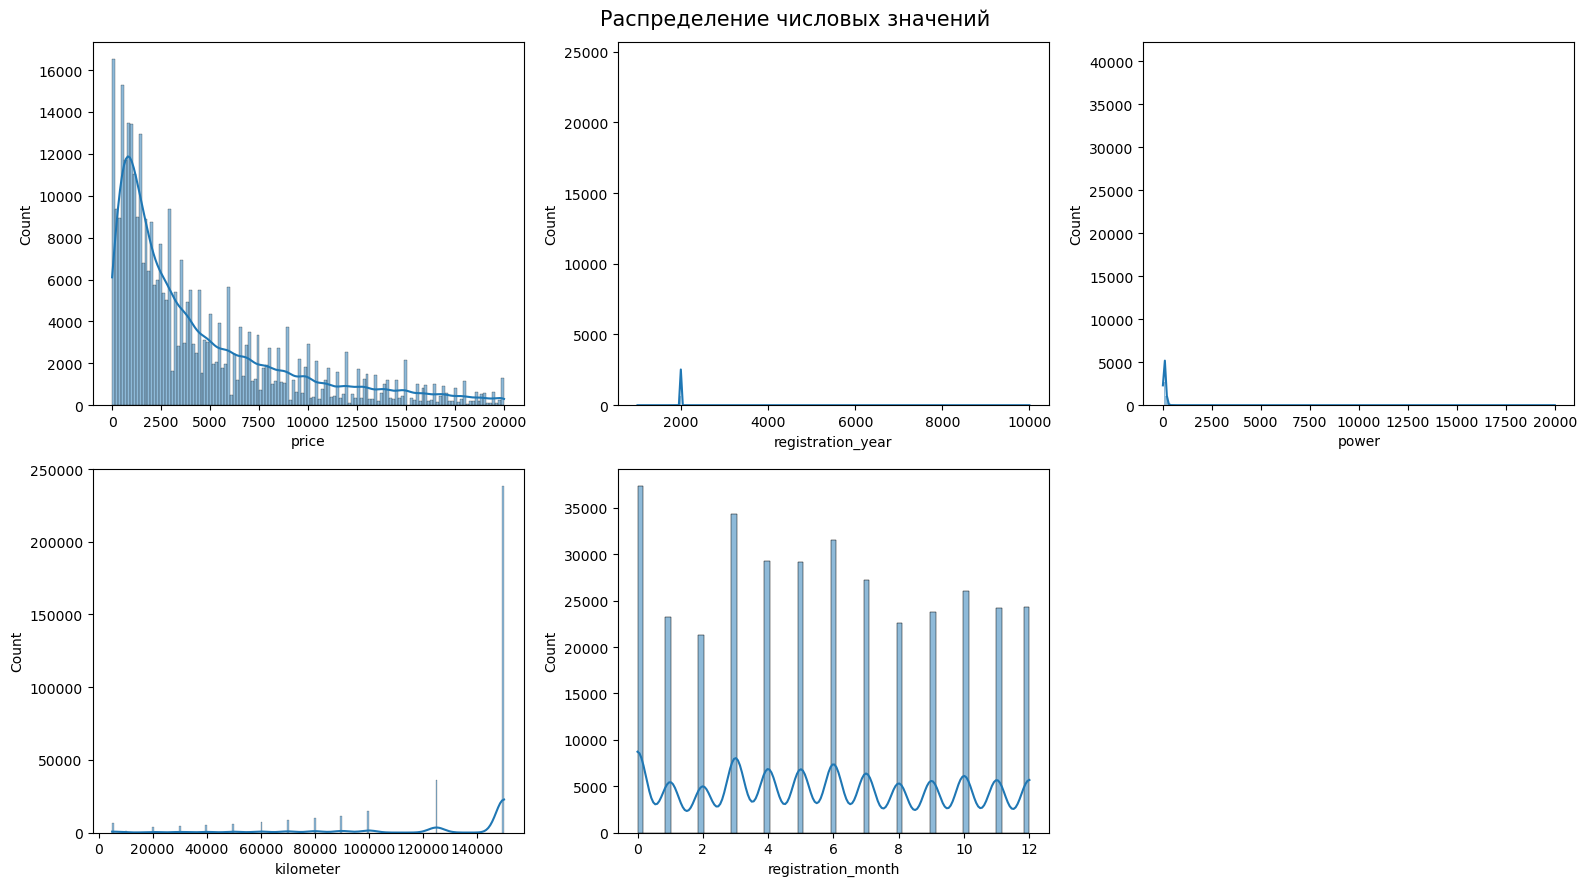

In [15]:
histplot(df)

Присутствуют аномалии в данных, которые надо отработать

Начнем с `registration_year`

In [16]:
df_good = df.loc[(1980 <= df['registration_year'])].copy(deep=True)
df_good = df_good.loc[df_good['date_crawled'].dt.year >= df_good['registration_year']]
df_good = df_good.drop('date_crawled', axis=1)

In [17]:
df_good = df_good.loc[(30 <= df_good['power']) & (df_good['power'] <= 400)]

In [18]:
df_good = df_good.loc[df_good['price'] >= 1000]

In [19]:
df_good = df_good.loc[df_good['registration_month'] > 0]

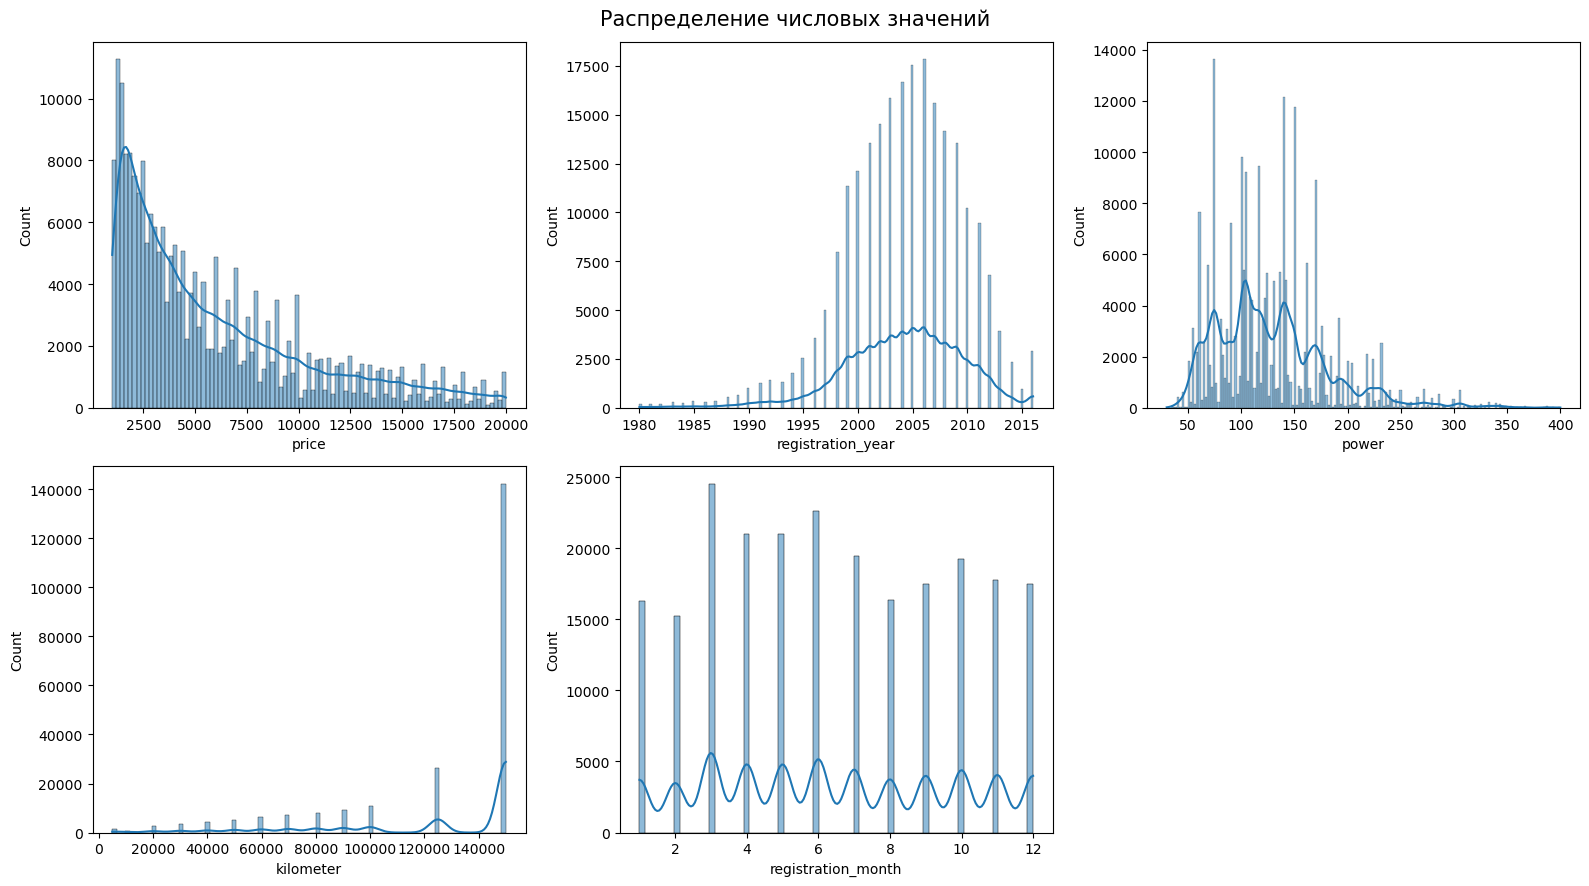

In [20]:
histplot(df_good)

Уже лучше

Заполним пропуски модой, по брендам машин

In [21]:
columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type'] # Выберем столбцы которые будем заполнять
unique_brands = list(df_good['brand'].unique()) # Сохраним название всех брендов машин
# Напишем двойной цикл по брендам машин и по столбцу, который мы заполняем
for brand in unique_brands:
    mode = ''
    for col in columns:
        # Используем структуру try except при случае, что моды для каких-то брендов машин нет
        try:
            mode = df_good.loc[df_good['brand'] == brand, col].mode().values[0] # Находим моду
            df_good.loc[df_good['brand'] == brand, col] = df_good.loc[df_good['brand'] == brand, col].fillna(mode) # Заполняем
        except:
            break # Выходим из первого цикла при ошибке

In [22]:
df_good.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                  1125
kilometer                 0
registration_month        0
fuel_type                39
brand                     0
repaired              23435
dtype: int64

После заполнения остались еще пропуски, рассмотрим их поподробнее

In [23]:
df_good.loc[df_good['fuel_type'].isna()]['brand'].unique()

array(['sonstige_autos'], dtype=object)

In [24]:
df_good.loc[df_good['model'].isna()]['brand'].unique()

array(['sonstige_autos'], dtype=object)

In [25]:
df_good.loc[df_good['brand'] == 'sonstige_autos'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1125 entries, 661 to 354321
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   price               1125 non-null   int64 
 1   vehicle_type        1125 non-null   object
 2   registration_year   1125 non-null   int64 
 3   gearbox             1125 non-null   object
 4   power               1125 non-null   int64 
 5   model               0 non-null      object
 6   kilometer           1125 non-null   int64 
 7   registration_month  1125 non-null   int64 
 8   fuel_type           1086 non-null   object
 9   brand               1125 non-null   object
 10  repaired            1024 non-null   object
dtypes: int64(5), object(6)
memory usage: 105.5+ KB


Похоже пропуски только в малоизвестном бренде машин и ни у одной из записей в таблице нет модели такой машины, поскольку записей немного удалим строки с этой маркой машины

In [26]:
df_good = df_good.drop(df_good.loc[df_good['brand'] == 'sonstige_autos'].index)

In [27]:
df_good.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              23334
dtype: int64

Осталась только колонка `repaired`. Рассмотрим медианы цен самый популярной марки автомобиля, в зависимости от ремонта

In [28]:
df_good.loc[df_good['brand'] == 'volkswagen'].pivot_table(index='repaired', values='price', aggfunc='median')

,price
repaired,
no,4800.0
yes,2850.0


In [29]:
df_good.loc[df_good['brand'] == 'volkswagen'].loc[df_good['repaired'].isna(), 'price'].median()

3000.0

Видимо, кто-то специально не указал, что был ремонт машины, чтоб повысить цену, поэтому выберем `yes` при заполенении пропусков

In [30]:
df_good['repaired'] = df_good['repaired'].fillna('yes')

In [31]:
df_good.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

После заполнения удалим дубликаты

In [32]:
df_good.duplicated().sum()

20057

In [33]:
df_good = df_good.drop_duplicates()

In [34]:
df_good

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,sedan,2016,auto,150,159,150000,12,petrol,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [35]:
corr_matrix = df_good.phik_matrix(interval_cols=['price', 'power'])

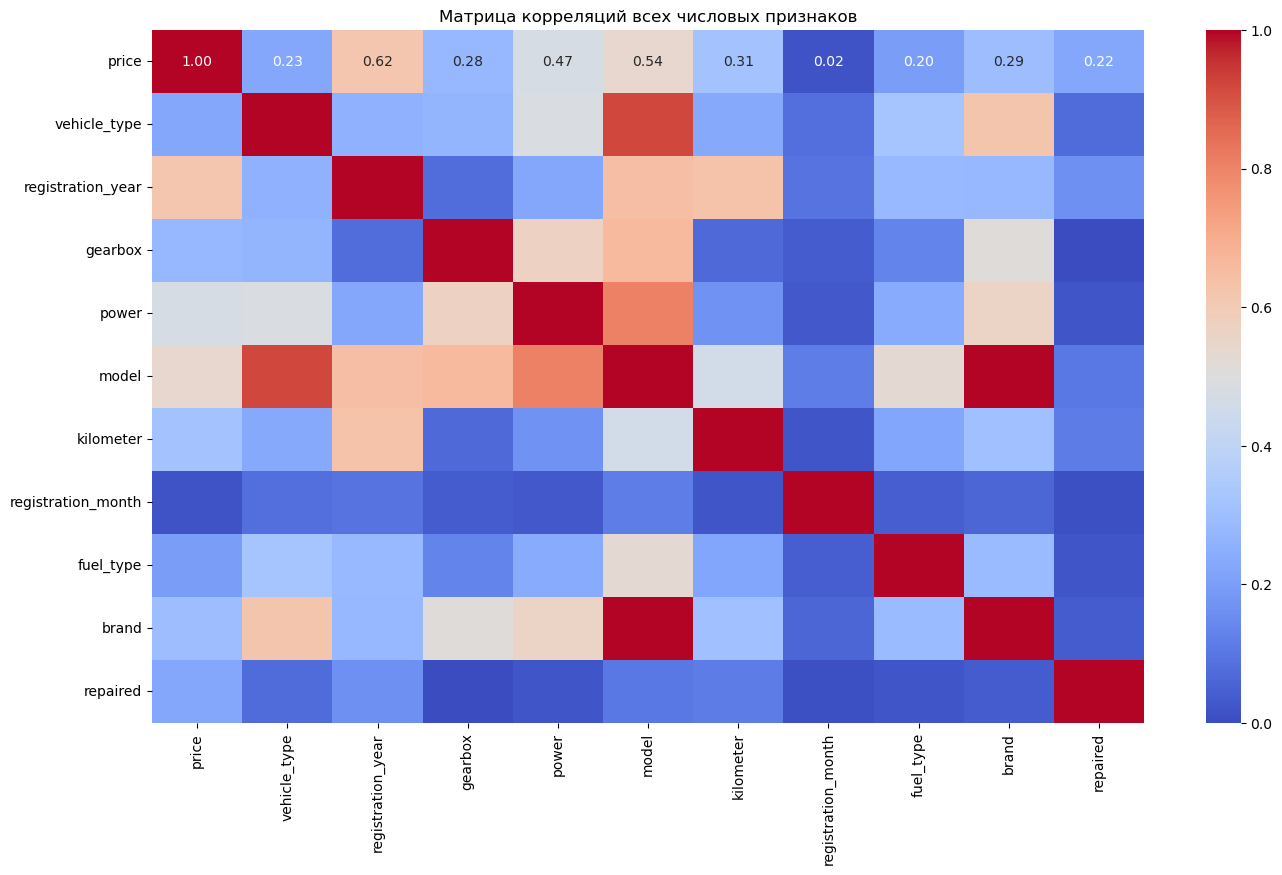

In [36]:
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Матрица корреляций всех числовых признаков')
plt.show()

У Бренда машины с моделью мультиколлинеарность, что логично, поэтому для ускорений вычислений, надо убрать одну из колонок, оставим модель, поскольку она важнее, исходя из корреляции, на формирование цены на машину.

Также удалим `registration_month`, поскольку из корр. анализа видно, что полезной информации она не несет.

Думаю стоит также убрать `vehicle_type` из-за высокой корреляцией с моделью машины

In [37]:
final_df = df_good.copy(deep=True)

**Промежуточные итоги**

Был подготовлен датафрэйм для обучения моделей. При подготовке были проделаны шаги:
1. Были отработаны аномалии в данных
2. Заполнены пропуски
3. Отработаны дубликаты
4. Проведен корреляционный анализ, на основе, которого были удалены некоторые столбцы

## Обучение моделей

In [38]:
num_columns = list(final_df.select_dtypes(include='number').columns)
num_columns.remove('price')
ordinal_columns = list(final_df.select_dtypes(exclude='number').columns)

X = final_df.drop('price', axis=1)
y = final_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
scaler = MinMaxScaler()

In [39]:
X_train_ordinal = encoder.fit_transform(X_train[ordinal_columns])
X_test_ordinal = encoder.transform(X_test[ordinal_columns])
encoder_col_names = encoder.get_feature_names_out()

X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ordinal = pd.DataFrame(X_train_ordinal, columns=encoder_col_names)
X_test_ordinal = pd.DataFrame(X_test_ordinal, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_ordinal_scaled = pd.concat([X_train_scaled, X_train_ordinal], axis=1)
X_test_ordinal_scaled = pd.concat([X_test_scaled, X_test_ordinal], axis=1)

### RandomForest

In [40]:
%%time
RF = RandomForestRegressor(criterion = "squared_error", random_state=RANDOM_STATE, n_estimators = 100, n_jobs=-1)
param_grid = {
    'max_depth': [None] + [i for i in range(2, 7)],
    'min_samples_split': range(2, 10)
             }
randomized_search = RandomizedSearchCV(
    RF, 
    param_grid, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_ordinal_scaled, y_train)

CPU times: total: 1min 37s
Wall time: 1min 38s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 2, 3, 4, 5, 6],
                                        'min_samples_split': range(2, 10)},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [41]:
print('\nRandomForest с лучшими гиперпараметрами:\n', randomized_search.best_estimator_)
print('Метрика RMSE:\n', -1*randomized_search.best_score_)


RandomForest с лучшими гиперпараметрами:
 RandomForestRegressor(min_samples_split=6, n_jobs=-1, random_state=42)
Метрика RMSE:
 1692.2096640770949


In [42]:
%%time
start = time()
RF = randomized_search.best_estimator_
RF.fit(X_train_ordinal_scaled, y_train)
end = time()
RF_fit_time = end - start

CPU times: total: 1min 38s
Wall time: 13.3 s


In [43]:
%%time
start = time()
RF.predict(X_train_ordinal_scaled)
end = time()
RF_predict_time = end - start

CPU times: total: 10.3 s
Wall time: 1.42 s


In [44]:
rmse_rf = -1*randomized_search.best_score_
print(f'RandomForest: {rmse_rf}')

RandomForest: 1692.2096640770949


### CatBoost

In [ ]:
%%time
catboost = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE')
param_grid = {'depth':[None] + [i for i in range(2, 7)], 'learning_rate': np.arange(0.1, 1, 0.3)}
catboost_grid = catboost.grid_search(param_grid,
            Pool(X_train, y_train, cat_features=ordinal_columns),
            cv=3,
            verbose=0,
            plot=False)

In [46]:
rmse_catboost = catboost_grid['cv_results']['test-RMSE-mean'][-1]

In [47]:
%%time
start = time()
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=0)
final_cat.fit(Pool(X_train, y_train, cat_features=ordinal_columns))
end = time()
catboost_fit_time = end - start

CPU times: total: 7min 42s
Wall time: 1min 20s


In [48]:
%%time
start = time()
final_cat.predict(X_train)
end = time()
catboost_predict_time = end - start

CPU times: total: 2.55 s
Wall time: 763 ms


In [49]:
print(f'Catboost: {rmse_catboost}')

Catboost: 1625.4993682260995


### LightGBM

In [50]:
%%time
X_test[ordinal_columns] = X_test[ordinal_columns].astype('category')
X_train[ordinal_columns] = X_train[ordinal_columns].astype('category')

param_grid = {'max_depth': range(10, 30), 'num_leaves': np.arange(20, 300, 20), 'learning_rate': np.arange(0.1, 1, 0.2)}
light = lgb.LGBMRegressor(random_state=RANDOM_STATE)
randomized_search=RandomizedSearchCV(light,
                                     param_grid,
                                     scoring='neg_root_mean_squared_error',
                                     random_state=RANDOM_STATE,
                                     cv=5,
                                     verbose=0,
                                     n_jobs=-1)
randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 155541, number of used features: 10
[LightGBM] [Info] Start training from score 5875.329347
CPU times: total: 8.64 s
Wall time: 1min


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                        'max_depth': range(10, 30),
                                        'num_leaves': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260,
       280])},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [51]:
print('\nLightGBM с лучшими гиперпараметрами:\n', randomized_search.best_estimator_)
print('Метрика RMSE:\n', -1*randomized_search.best_score_)


LightGBM с лучшими гиперпараметрами:
 LGBMRegressor(max_depth=18, num_leaves=200, random_state=42)
Метрика RMSE:
 1582.2464701654233


In [52]:
%%time
start = time()

light = randomized_search.best_estimator_
light.fit(X_train, y_train)

end = time()
light_fit_time = end - start

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 155541, number of used features: 10
[LightGBM] [Info] Start training from score 5875.329347
CPU times: total: 7.66 s
Wall time: 2.33 s


In [53]:
%%time

start = time()

light.predict(X_train)

end = time()
light_predict_time = end - start
rmse_light = -1*randomized_search.best_score_
print(f'Light:{rmse_light}')

Light:1582.2464701654233
CPU times: total: 4.44 s
Wall time: 1.17 s


**Промежуточные итоги**

Были обучены три модели:
1. RandomForest
2. Catboost
3. LightGBM

## Анализ моделей

In [54]:
models = pd.DataFrame({'Модель': ['RandomForest', 'Catboost', 'LightGBM'],
                       'RMSE при кросс-валидации': [rmse_rf, rmse_catboost, rmse_light],
                       'Время обучения в с.': [RF_fit_time, catboost_fit_time, light_fit_time],
                       'Время прогнозирования в с.': [RF_predict_time, catboost_predict_time, light_predict_time]
                      })
models

,Модель,RMSE при кросс-валидации,Время обучения в с.,Время прогнозирования в с.
0,RandomForest,1692.209664,13.318552,1.419556
1,Catboost,1625.499368,80.199595,0.762724
2,LightGBM,1582.246470,2.329318,1.174831


CatBoost проигрывает по всем параметрам, кроме времени прогнозирования.

У LightGBM время прогноза чуть выше, но у нее самая низкая метрика и время обучения, поэтому она оптимальна

Рассчитаем итоговую метрику на тестовой выборке

In [55]:
%%time
start = time()
light_test_rmse = mean_squared_error(y_test, light.predict(X_test))**(.5)
end = time()
light_test_time = end - start
print(f'LightGBM RMSE на тестовой выборке: {light_test_rmse}')
print(f'LightGBM время обучения на тренировочной выборке: {light_fit_time}')
print(f'LightGBM время прогнозирования на тестовой выборке: {light_test_time}')

LightGBM RMSE на тестовой выборке: 1582.5667509704915
LightGBM время обучения на тренировочной выборке: 2.329317569732666
LightGBM время прогнозирования на тестовой выборке: 0.37482714653015137
CPU times: total: 1.3 s
Wall time: 375 ms


- Была проведена кросс-валидация для трех выбранных моделей, благодаря, который были подобраны лучшие гиперпараметры по заданной метрике RMSE
- Был проведен тестировани полученных моделей на тренировочной выборке, для нахождения RMSE, времени обучения и прогнозирования
- Был проведен анализ вышеописанных показателей, из которых был сделан вывод, что **самая оптимальная модель для данной задачи - это LightGBM**